# Assignment 4

## Problem 1 [20 Points]:

Deeplearning has great potential at making in-roads with traditional scientific and engineering research. In this question, we'll consider one good example of this where we'll be performing some predictions working with the [Higgs Dataset](http://mlphysics.ics.uci.edu/data/higgs/) which has been generated from Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. Note that this dataset consists of 11 million datapoints. We'll be using a subset of these for training as described below.

Our classification task is that given the 28 features, we want to predict whether the observation is a “signal” (class 1) or the background (class 0). Perform an 80:20 split of the data into training and testing. Before passing your inputs to the model, normalize your inputs to have zero mean and unit variance.

Build a model using ReLU for activation and glorot-normal initialization. Use binary cross entropy as the loss function, and perform the optimization using the Adam optimizer with default settings. Train your model till you observe a convergence of the loss curves. Plot curves showing evolution of the loss and accuracy when evaluated over the training and the testing data. Consider a 2 layer MLP of width 64.

- Consider your dataset to be randomly selected 1100 data-points from the main dataset. Perform the train / test split on this subset and use these for training your model. What do you observe in this case?
- Consider your dataset to be randomly selected 110000 data-points from the main dataset. Again, perform the train / test split on this subset and use these for training your model. Do your results differ from the earlier case? 
- One way to quantify overfitting is by understanding how sensitive the function is to input noise. For any function f(x), we have that the sensitivity can be computed as
$$\int \left(\frac{df}{dx}\right)^2 p(x) dx = \mathbb{E}((f')^2)$$
This can be estimated by adding some small noise $w$ to the input $x$. For a small enough noise, we have that:
$$f(x + w) \approx f(x) + \frac{df}{dx} w$$ 
We can choose the noise to be drawn from a normal distribution with mean 0 and variance $\sigma^2(w)$. The variance of $f(x + w)$ is given by:
$$\sigma^2(f(x + w)) = \sigma^2(f(x) + f'(x)w) = \sigma^2(f) + \sigma^2(w) \mathbb{E}((f')^2)$$
Using this strategy, estimate the sensitivity of the 2 models you trained earlier. Note that you need to estimate over several trials and take the average. Is it consistent with your findings?


In [ ]:
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad, device_put,nn
from jax.example_libraries import optimizers

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [ ]:
def MLP(layers, activation=nn.relu):
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = nn.sigmoid(np.dot(inputs, W) + b)
      return outputs
  return init, apply

In [ ]:
@optimizers.optimizer
def sgd(step_size):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        return x0
    def update(i, g, x):
        return x - step_size(i) * g
    def get_params(x):
        return x
    return init, update, get_params

@optimizers.optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * np.square(g) + b2 * v  # Second moment estimate.
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

In [ ]:
# Defining the keys for the model and the data loader:
# Doing this before due to some strange bug on JAX (REF:https://github.com/google/jax/issues/15084)
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:
class MLPregression:
    # Initialize the class
    def __init__(self, layers, rng_key):
        # MLP init and apply functions
        self.net_init, self.net_apply = MLP(layers)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch 
        outputs = self.net_apply(params, inputs)
        #final_output=nn.sigmoid(outputs)
        loss = -np.mean(targets*np.log(outputs+10**(-7))+(1-targets)*np.log(1-outputs+10**(-7)))
        return loss 

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [ ]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 norm_const=((0.0, 1.0), (0.0, 1.0)), 
                 batch_size=128, 
                 rng_key = random.PRNGKey(123)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.norm_const = norm_const
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        (mu_X, sigma_X), (mu_Y, sigma_Y) = self.norm_const
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[idx,:]
        targets = Y[idx,:]
        inputs = (inputs - mu_X)/sigma_X
        targets = (targets - mu_Y)/sigma_Y
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [ ]:
!wget http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz

--2023-04-12 23:58:59--  http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz
Resolving mlphysics.ics.uci.edu (mlphysics.ics.uci.edu)... 128.195.1.86
Connecting to mlphysics.ics.uci.edu (mlphysics.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-gzip]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G   102MB/s    in 26s     

2023-04-12 23:59:26 (101 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [ ]:
import pandas as pd
n_samples=1100
data=pd.read_csv('HIGGS.csv.gz',compression='gzip')


In [ ]:
data=np.array(data)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

n_samples=1100

sampled_rows=onp.random.choice(data.shape[0],n_samples,replace=False)
# Split into features and labels
X = data[sampled_rows,1:29]
y = data[sampled_rows,0:1]

# Define training and testing set sizes
train_size = int(0.8 * n_samples)
test_size = len(data) - train_size

# Split into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

mu_X, sigma_X = X_train.min(0), 2*X_train.max(0)
mu_Y, sigma_Y = 0*y_train.mean(0), np.array([1.0])
norm_const = (mu_X, sigma_X), (mu_Y, sigma_Y)
dataset_ = DataGenerator(X_train, y_train, norm_const, batch_size=128, rng_key = rng_dataloader)

In [ ]:
layers=[X_train.shape[1], 64, 64, 1]
model = MLPregression(layers, rng_key = rng_model)

In [ ]:
model.train(dataset_, nIter=10000)

100%|██████████| 10000/10000 [00:15<00:00, 655.73it/s, Loss=0.0008156722]


In [ ]:
X_star = (X_train - mu_X)/sigma_X

# Predict
opt_params = model.get_params(model.opt_state)
Y_pred = model.predict(opt_params, X_star)
# De-normalize predicted outputs
Y_pred = Y_pred*sigma_Y + mu_Y

train_error =np.mean((Y_pred-y_train)**2)
train_acc=(1-train_error)*100

In [ ]:
X_star = (X_test - mu_X)/sigma_X

# Predict
opt_params = model.get_params(model.opt_state)
Y_pred = model.predict(opt_params, X_star)
# De-normalize predicted outputs
Y_pred = Y_pred*sigma_Y + mu_Y

Training Accuracy = 99.999748 
Testing Accuracy = 53.965782 


Text(0, 0.5, 'Loss')

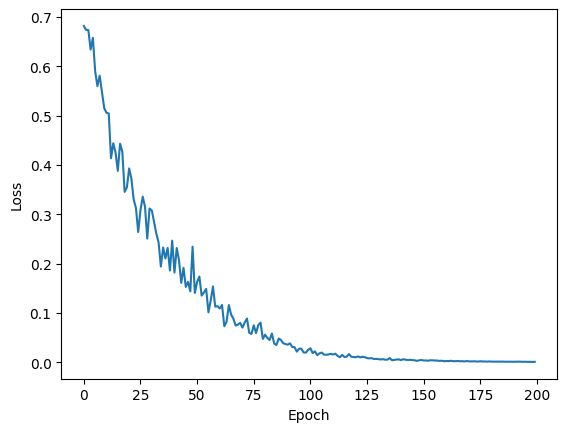

In [ ]:
test_error =np.mean(np.abs(Y_pred-y_test))
test_acc=(1-test_error)*100
print('Training Accuracy = %f ' %(train_acc))
print('Testing Accuracy = %f ' %(test_acc))

plt.figure()
plt.plot(np.array(model.loss_log))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
rng_test=random.PRNGKey(123)

sd=0.001
n_trials=50000
def compute_sensitivity(rng_key, model, opt_params, X, mu_X, sigma_X, sd, n_trials=20000):
    X_act = (X - mu_X) / sigma_X
    Y_act = model.predict(opt_params, X_act)

    sensitivity = 0
    for i in range(n_trials):
        key, rng_key = random.split(rng_key)
        pert_X = X_act + sd * random.normal(key=key, shape=X.shape)
        pert_out = model.predict(opt_params, pert_X)
        sensitivity += (np.std(pert_out)**2 - np.std(Y_act)**2) / sd**2

    return sensitivity / n_trials

sensitivity = (compute_sensitivity(rng_test, model, opt_params, X, mu_X, sigma_X, sd,n_trials))
print(sensitivity)
X_sens_test=(X-mu_X)/sigma_X

58.870502


In [ ]:
n_samples=110000

sampled_rows=onp.random.choice(data.shape[0],110000,replace=False)
# Split into features and labels
X = data[sampled_rows,1:29]
y = data[sampled_rows,0:1]

# Define training and testing set sizes
train_size = int(0.8 * n_samples)
test_size = len(data) - train_size

# Split into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
mu_X, sigma_X = X_train.min(0), 2*X_train.max(0)
mu_Y, sigma_Y = 0*y_train.mean(0), np.array([1.0])
norm_const = (mu_X, sigma_X), (mu_Y, sigma_Y)
dataset = DataGenerator(X_train, y_train, norm_const, batch_size=128*100, rng_key = rng_dataloader)

In [ ]:
layers=[X_train.shape[1], 64, 64, 1]
model = MLPregression(layers, rng_key = rng_model)

In [ ]:
model.train(dataset, nIter=100000)

100%|██████████| 100000/100000 [02:32<00:00, 657.51it/s, Loss=0.48922202]


In [ ]:
X_star = (X_train - mu_X)/sigma_X

# Predict
opt_params = model.get_params(model.opt_state)
Y_pred = model.predict(opt_params, X_star)
# De-normalize predicted outputs
Y_pred = Y_pred*sigma_Y + mu_Y

train_error =np.mean((Y_pred-y_train)**2)
train_acc=(1-train_error)*100

In [ ]:
X_star = (X_test - mu_X)/sigma_X

# Predict
opt_params = model.get_params(model.opt_state)
Y_pred = model.predict(opt_params, X_star)
# De-normalize predicted outputs
Y_pred = Y_pred*sigma_Y + mu_Y

Training Accuracy = 83.952576 
Testing Accuracy = 64.528084 
Error 3.547191e-01


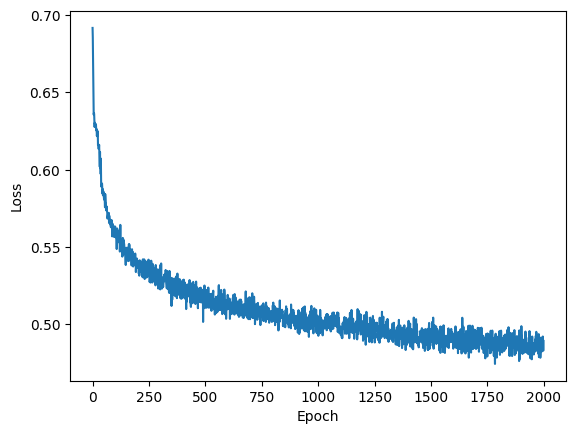

In [ ]:
error = np.mean(np.abs(Y_pred-y_test))
test_acc=(1-error)*100
print('Training Accuracy = %f ' %(train_acc))
print('Testing Accuracy = %f ' %(test_acc))

plt.figure()
plt.plot(np.array(model.loss_log))
plt.xlabel('Epoch')
plt.ylabel('Loss')

print('Error %e' %(error))

In [ ]:
rng_test=random.PRNGKey(123)

sd=0.001
n_trials=50000
def compute_sensitivity(rng_key, model, opt_params, X, mu_X, sigma_X, sd, n_trials=20000):
    X_act = X
    Y_act = model.predict(opt_params, X_act)

    sensitivity = 0
    for i in range(n_trials):
        key, rng_key = random.split(rng_key)
        pert_X = X_act + sd * random.normal(key=key, shape=X.shape)
        pert_out = model.predict(opt_params, pert_X)
        sensitivity += (np.std(pert_out)**2 - np.std(Y_act)**2) / sd**2

    return sensitivity / n_trials

sensitivity = (compute_sensitivity(rng_test, model, opt_params, X_sens_test, mu_X, sigma_X, sd))
print(sensitivity)

164.44843


The model 1 with less sample shows that the model is overfitting.
When we increase the data points, the signs of overfitting goes away. This can be seen from the training and testing accuracy of the model. The sensitivity should also reflect the same thing.


The last part of the question , the sensitivity part was implemented after discussing with Cyril Jose.



## Problem 2 [20 Points]:

Train a convolutional neural network on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The network architecture should be as follows:

- Input layer: Accepts 32x32x3 images
- Convolution layer: 6 filters, filter size 5x5x3, stride 1
- ReLU layer: Accepts and returns a 32x32x6 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 12 filters, filter size 5x5x6, stride 1
- ReLU layer: Accepts and returns a 16x16x12 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 24 filters, filter size 5x5x12, stride 1
- ReLU layer: Accepts and returns a 8x8x24 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Fully connected network with 2 hidden layers: Accepts a flattened tensor of dimension 4x4x24 and outputs a 10-dimensional tensor containing the predicted class labels. The layer dimensions should be [384,120,84,10].

Notice how in each layer the number of filters is doubled, while the feature resolution is halved (_hint: make sure you use the appropriate amount of padding to achieve this_). Use the multi-class cross entropy loss function and the Adam optimizer with a learning rate of $10^{-3}$. Train the network for a total of 20000 iterations using a batch size of 128 images. Report the loss as a function of the training iterations, and the resulting confusion matrix for the test data-set. What do you notice here? Propose changes to improve the accuracy over the test set, and verify that you see an improvement of atleast 3% with your changes.


In [ ]:
# your code here
import jax.numpy as np
import numpy as onp
from jax import vmap, grad, random, jit
from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax,Dropout
from jax.nn import one_hot

import itertools
from functools import partial
from tqdm import trange
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_filters(conv, shape, title):
    plt.figure(figsize=(5,4))
    cnt=0
    m, n = shape
    for i in range(m):
      for j in range(n):
          cnt+=1
          plt.subplot(m,n,cnt)   
          plt.imshow(conv[0,:,:,cnt]) 
          plt.axis('off')
    fig = plt.gcf()
    fig.suptitle(title)

In [ ]:
def CNN():
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu,MaxPool((2, 2), (2, 2)), Flatten,
                              Dense(384), Relu, 
                              Dense(120), Relu, 
                              Dense(84), Relu, 
                              Dense(10), Softmax)
    return init, apply

In [ ]:
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:
class CNNclassifier:
    # Initialize the class
    def __init__(self):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_model, ( -1,32, 32, 3))

        # Optimizer initialization and update functions
        lr = 1e-3
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        jitter=10**-14
        loss = -np.sum(labels * np.log(outputs+jitter)) / images.shape[0]
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter=10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [ ]:
import torchvision as tv
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [ ]:
train = tv.datasets.CIFAR10('./', download=True, train=True)
train_images = np.array(train.data)
train_labels = np.array(train.targets)

# Input shape should be (NxWxHxC) and normalized to [0,1]
train_images = train_images[:,:,:]/255.
# Labels should be a one-hot vector
num_classes = train_labels.max()+1
train_labels = one_hot(train_labels, num_classes)

# Create data iteraror
train_dataset = DataGenerator(train_images, train_labels, batch_size=128, rng_key = rng_dataloader)

100%|██████████| 170498071/170498071 [00:05<00:00, 30225363.73it/s]


Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
np.shape(train_images)

In [ ]:
model = CNNclassifier()

100%|██████████| 20000/20000 [00:52<00:00, 380.18it/s, Loss=0.026448987]


Text(0, 0.5, 'Loss')

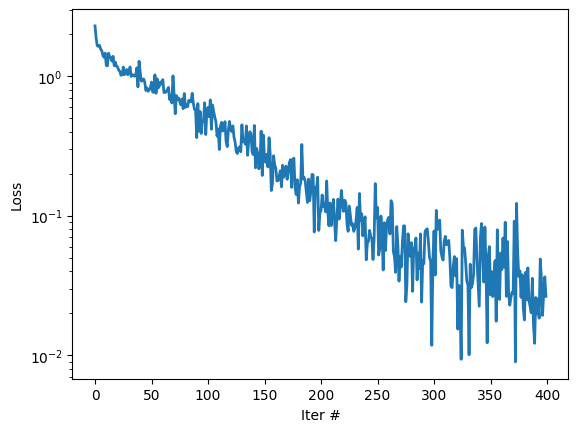

In [ ]:
model.train(train_dataset, nIter=20000)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
test = tv.datasets.CIFAR10('./', download=True, train=False)
test_images = np.array(test.data)
test_labels = np.array(test.targets)

# Input shape should be (NxWxHxC) and normalized to [0,1]
test_images = test_images[:,:,:]/255.
test_labels = one_hot(test_labels, num_classes)

# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=6)
test_data = iter(test_dataset)

Files already downloaded and verified


In [ ]:
@jit
def accuracy(params, batch):
    images, labels = batch
    outputs = model.predict(params, images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy(opt_params, (test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 63.11000061035156%


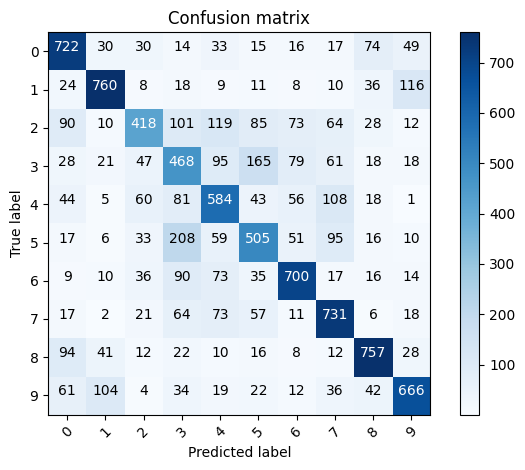

In [ ]:
outputs = model.predict(opt_params, test_images)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=False)

In [ ]:
def CNN_1(key,dropout_rate=0.9):
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                             Relu, MaxPool((2, 2), (2, 2)),
                              Dropout(dropout_rate,mode=key),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Dropout(dropout_rate,mode=key),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu,MaxPool((2, 2), (2, 2)), Flatten,
                              Dropout(dropout_rate,mode=key),
                              Dense(384), Relu, 
                              Dropout(dropout_rate,mode=key),
                              Dense(120), Relu, 
                              Dropout(dropout_rate,mode=key),
                              Dense(84), Relu, 
                              Dropout(dropout_rate,mode=key),
                              Dense(10), Softmax)
    return init, apply

In [ ]:
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:
class CNNclassifier_1:
    # Initialize the class
    def __init__(self,dropout_rate=0.5):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN_1('train')
        _,self.test=CNN_1('test')
        _, params = self.net_init(rng_model, ( -1,32, 32, 3))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        images, labels = batch
        key=random.PRNGKey(5)
        outputs = self.net_apply(params, images,rng=key)
        jitter=10**-14
        loss = -np.sum(labels * np.log(outputs+jitter)) / images.shape[0]
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter=10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):

        outputs = self.test(params, inputs,rng=random.PRNGKey(25))
        return outputs

In [ ]:
model1=CNNclassifier_1()

100%|██████████| 20000/20000 [00:51<00:00, 392.13it/s, Loss=0.6321814]


Text(0, 0.5, 'Loss')

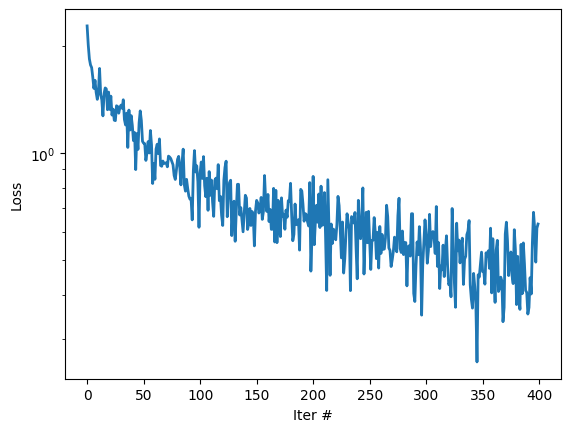

In [ ]:
model1.train(train_dataset, nIter=20000)
opt_params = model1.get_params(model1.opt_state)
# Plot loss
plt.figure()
plt.plot(model1.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
test = tv.datasets.CIFAR10('./', download=True, train=False)
test_images = np.array(test.data)
test_labels = np.array(test.targets)

# Input shape should be (NxWxHxC) and normalized to [0,1]
test_images = test_images[:,:,:]/255.
test_labels = one_hot(test_labels, num_classes)

# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=6)
test_data = iter(test_dataset)

Files already downloaded and verified


In [ ]:
@jit
def accuracy(params, batch):
    images, labels = batch
    outputs = model1.predict(params, images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy(opt_params, (test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 69.40999603271484%


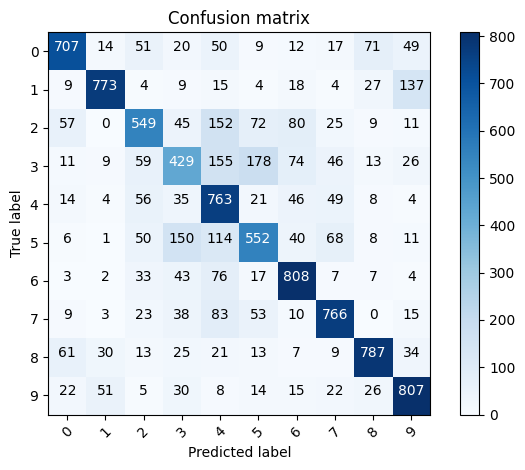

In [ ]:
outputs = model1.predict(opt_params, test_images)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(test_labels,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=False)

In [ ]:
def CNN_2():
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(48, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)), Flatten,
                              Dense(384), Relu, 
                              Dense(120), Relu, 
                              Dense(84), Relu, 
                              Dense(10), Softmax)
    return init, apply

In [ ]:
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:
class CNNclassifier_2:
    # Initialize the class
    def __init__(self):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_model, ( -1,32, 32, 3))

        # Optimizer initialization and update functions
        lr = 1e-3
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        jitter=10**-14
        loss = -np.sum(labels * np.log(outputs+jitter)) / images.shape[0]
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter=10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [ ]:
model2=CNNclassifier_2()

100%|██████████| 20000/20000 [00:42<00:00, 473.16it/s, Loss=0.06401675]


Text(0, 0.5, 'Loss')

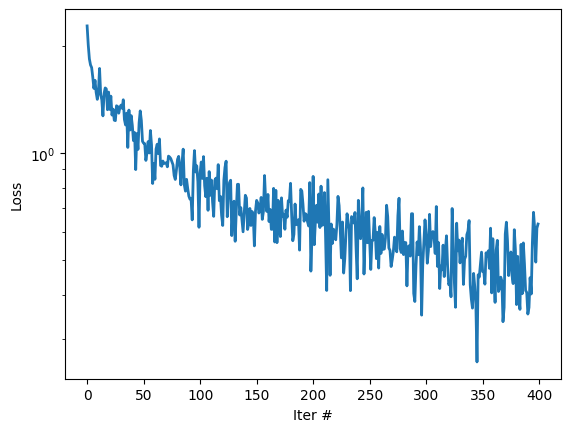

In [ ]:
model2.train(train_dataset, nIter=20000)
opt_params = model1.get_params(model1.opt_state)
# Plot loss
plt.figure()
plt.plot(model1.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
test = tv.datasets.CIFAR10('./', download=True, train=False)
test_images = np.array(test.data)
test_labels = np.array(test.targets)

# Input shape should be (NxWxHxC) and normalized to [0,1]
test_images = test_images[:,:,:]/255.
test_labels = one_hot(test_labels, num_classes)

# Create data iteraror
test_dataset = DataGenerator(test_images, test_labels, batch_size=6)
test_data = iter(test_dataset)

Files already downloaded and verified


In [ ]:
@jit
def accuracy(params, batch):
    images, labels = batch
    outputs = model1.predict(params, images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy(opt_params, (test_images, test_labels))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 69.40999603271484%


There are two approaches to increase the accuracy:
1.Increase the number of layers
2.Introduce Dropout
Dropout is generally more effective than increasing the number of layers for improving generalization and accuracy in neural networks. It directly addresses the problem of overfitting, is computationally more efficient, and can be effective even for relatively shallow networks.


## Problem 3 [20 Points]:

A subcritically damped pendulum is described by the equation
$$x'' = -\sin(x) - \mu x'$$

where $x$ is the angle of the pendulum and $\mu$ is a damping parameter.

(i) Create a time-series data-set by using [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to integrate this system in the interval $t\in[0,50]$ using $2,000$ time-steps using an initial condition of $x(t=0) = 0$,  $x'(t=0) = 1.2$. Plot the evolution of the pendulum angle and angular velocity as a function of time.

(ii) Implement an LSTM (Long short-term memory) with 8 lags, one hidden layer with 32 neurons, and a hyperbolic tangent activation function. Train the network using the data-set generated for $20,000$ stochastic gradient descent steps using the Adam optimizer with a learning rate of $10^{-3}$ and a mini-batch size of 128. Use the trained model to perform **one-step-ahead predictions** until the final time $T=60$, and compare them against the true data. Plot the predicted and exact signals, and report their discrepancy within the test interval in the relative $\mathbb{L}_{2}$ norm.


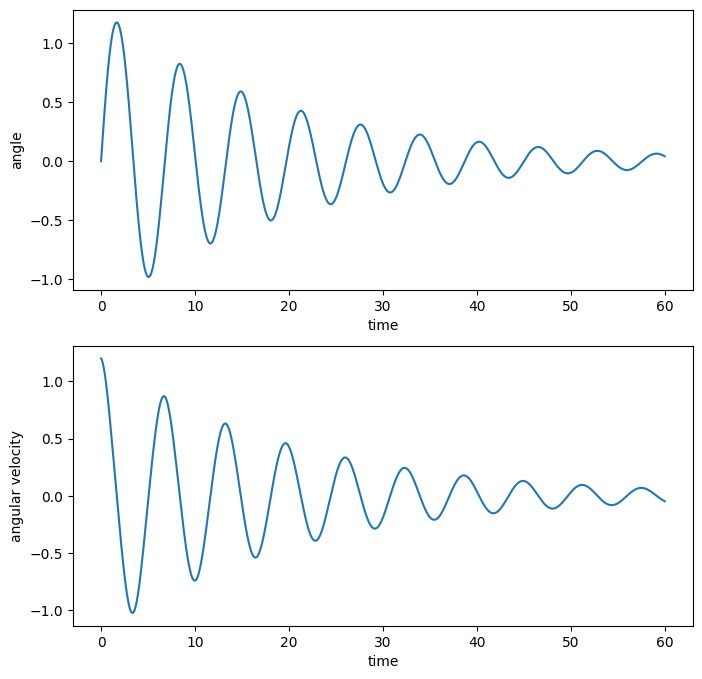

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

# Define the differential equation
def pendulum(y, t, mu):
    x, v = y
    dxdt = v
    dvdt = -jnp.sin(x) - mu*v
    return jnp.array([dxdt, dvdt])

# Set the initial conditions and integration parameters
t0, tf = 0, 60
n = 2400
t_eval = jnp.linspace(t0, tf, n)
y0 = jnp.array([0.0, 1.2])
mu = 0.1

# Create a function for integrating the system over the time span
ode_fn = jit(lambda y, t, mu: pendulum(y, t, mu))
y_traj = odeint(ode_fn, y0, t_eval, mu)

# Plot the evolution of the pendulum angle and angular velocity as a function of time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(t_eval, y_traj[:, 0], label='angle')
ax1.set_xlabel('time')
ax1.set_ylabel('angle')
ax2.plot(t_eval, y_traj[:, 1], label='angular velocity')
ax2.set_xlabel('time')
ax2.set_ylabel('angular velocity')
plt.show()





In [ ]:
import jax.numpy as np
from jax import vmap, grad, random, jit,nn
from jax.example_libraries import optimizers
from jax.lax import scan, fori_loop
# from jax.ops import index, index_update

import itertools
from functools import partial
from tqdm import trange
from matplotlib import pyplot as plt


In [ ]:
# Efficient implementation via lax.scan
def LSTM(depth, dims, activation=np.tanh):
  input_dim, hidden_dim, output_dim = dims
  def init(rng_key):
      def glorot_init(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          return W
      keys = random.split(rng_key, 9)
      # Input layer
      glorot=vmap(glorot_init,in_axes=(0,None,None))
      U = glorot(keys[0:4], input_dim, hidden_dim)
      b = np.zeros((4,hidden_dim))
      # Transition dynamics
      W = glorot(keys[4:8], hidden_dim, hidden_dim)
      # Output layer
      V = glorot_init(keys[9], hidden_dim, output_dim)
      c = np.zeros(output_dim)
      return U, b, W, V, c
  def scan_fn(params, gates, inputs):
      U, b, W, _, _ = params
      H,s_previous=gates
      uo,us,ui,uf=U
      bo,bs,bi,bf=b
      wo,ws,wi,wf=W
      f=nn.sigmoid(np.dot(H,wf)+np.dot(inputs,uf)+bf)
      i=nn.sigmoid(np.dot(H,wi)+np.dot(inputs,ui)+bi)
      s_star=np.tanh(np.dot(H,ws)+np.dot(inputs,us)+bs)
      o=nn.sigmoid(np.dot(H,wo)+np.dot(inputs,uo)+bo)
      s=f*s_previous+i*s_star
      H = o*activation(s) 
      return np.array([H,s]), H
  def apply(params, inputs):
      _, _, _, V, c = params
      f = partial(scan_fn, params)
      H = np.zeros((inputs.shape[1], hidden_dim))
      s_prev=np.zeros((inputs.shape[1], hidden_dim))
      init_states=np.array([H,s_prev])
      carry, acc = scan(f, init_states, inputs)
      H,s=carry
      H = np.dot(H,V) + c
      return H
  return init, apply

In [ ]:
class Seq2Seq:
    # Initialize the class
    def __init__(self, depth, dims, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = LSTM(depth, dims)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = 1e-3
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        loss = np.mean((targets-outputs)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [ ]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key
    
    @partial(jit, static_argnums=(0,))  
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[:,idx,:]
        targets = Y[idx,:]
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [ ]:
from jax import grad, jit, vmap
from jax.experimental.ode import odeint

def create_lags(data, lags):
    N = len(data)-lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    for i in range(N):
        X = X.at[:,i,:].set(data[i:(i+lags),:])
        Y = Y.at[i,:].set(data[i+lags,:])
    return X, Y

def pendulum(y, t, mu):
    x, v = y
    dxdt = v
    dvdt = -np.sin(x) - mu*v
    return np.array([dxdt, dvdt])
                     
t0, tf = 0, 60
n = 2400
t_eval = np.linspace(t0, tf, n)
y0 = np.array([0.0, 0.1])
mu = 0.1

# Create a function for integrating the system over the time span

data= y_traj

# Normalize
mu, std = data.mean(0), data.std(0)
norm_data = (data - mu)/std

# Use 2/3 of all data as training Data
train_size = int(len(norm_data) * (2.0/3.0))
training_data = norm_data[0:train_size,:]

# reshape X and Y
# X has the form lags x data x dim
# Y has the form data x dim
lags = 8
X, Y = create_lags(training_data, lags)
dataset = DataGenerator(X, Y, batch_size=128)

In [ ]:
mu.shape

In [ ]:
inp_dim = X.shape[-1]
out_dim = Y.shape[-1]
hid_dim = 32
model = Seq2Seq(lags, (inp_dim, hid_dim, out_dim))

100%|██████████| 20000/20000 [02:54<00:00, 114.86it/s, Loss=1.0774214e-06]


Text(0, 0.5, 'Loss')

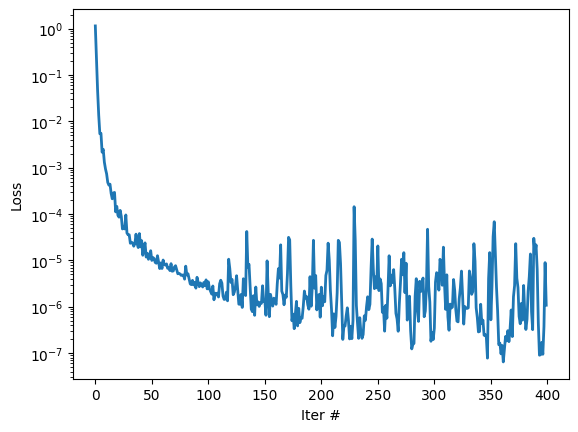

In [ ]:
model.train(dataset, nIter=20000)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
def one_step_pred(inputs, step):
      outputs = model.predict(opt_params, inputs)
      inputs = inputs.at[:-1,...].set(inputs[1:,...])
      inputs = inputs.at[-1,...].set(outputs)
      return inputs, outputs[-1,:]

steps = len(norm_data)-lags
_, outputs = scan(one_step_pred, X[:,0:1,:], np.arange(steps))

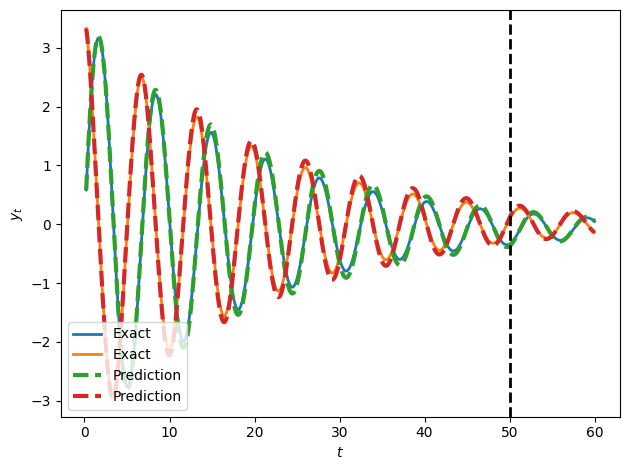

In [ ]:
plt.figure()
plt.plot(t_eval[lags:],norm_data[lags:], '-', lw = 2, label = "Exact")
plt.plot(t_eval[lags:],outputs, '--', lw = 3, label = "Prediction")
plt.axvline(50, color='black', ls='--', lw=2)
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend(loc='lower left')
plt.tight_layout()

In [ ]:
#Calculating norm

disp_test=norm_data[(train_size+lags):,0]*std[0]+mu[0]
disp_pred=outputs[train_size:,0]*std[0]+mu[0]
l2_norm = jnp.linalg.norm(disp_pred - disp_test) / jnp.linalg.norm(disp_test)
print(f"Relative L2 norm of error in angular displacement: {l2_norm:.6f}")

omega_test=norm_data[(train_size+lags):,1]*std[1]+mu[1]
omega_pred=outputs[train_size:,1]*std[1]+mu[1]
l2_norm = jnp.linalg.norm(omega_pred - omega_test) / jnp.linalg.norm(omega_test)
print(f"Relative L2 norm of error in angular velocity: {l2_norm:.6f}")

Relative L2 norm of error in angular displacement: 0.157477
Relative L2 norm of error in angular velocity: 0.151749



## Problem 4 [20 Points]:

Simulation of complex physical systems described by nonlinear partial differential equations (PDEs) is central to engineering and physical science. We'll now train a neural network to solve a PDE given the boundary conditions. Till now, we have trained an MLP through data and penalize the network until it learns what we desire. However, in the case of PDEs, we can use knowledge of the known PDE to guide the training. Using the core idea of [PINNs](https://www.sciencedirect.com/science/article/pii/S0021999118307125), train a network to solve the Poisson equation 
$$u_{xx} + u_{yy} = -\sin (\pi x) \sin(\pi y)$$
with the following BCs:
$$u(0, y) = u(1, y) = u(x, 1) = u(x, 1) = 0$$

Utilize 10000 collocation points in the domain to enforce the PDE and 100 data-points on each boundary to enforce boundary condition. Compare your solution against the analytic solution and report error in the relative $\mathbb{L}_{2}$ norm.


In [ ]:
# your code here
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad, device_put
from jax.example_libraries import optimizers
import pandas as pd
from matplotlib import cm
import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
import math
     

In [ ]:
def MLP(layers, activation=np.tanh):
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, x,y):
      inputs=np.concatenate([x,y],axis=1)
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [ ]:
def sgd(step_size):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        return x0
    def update(i, g, x):
        return x - step_size(i) * g
    def get_params(x):
        return x
    return init, update, get_params

@optimizers.optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * np.square(g) + b2 * v  # Second moment estimate.
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

In [ ]:
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [ ]:
class MLPregression:
    # Initialize the class
    def __init__(self, layers, rng_key):
        # MLP init and apply functions
        self.net_init, self.net_apply = MLP(layers)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def PDEerror(self,x,y,u):
      
      u_x=lambda x,y:grad(lambda x,y: np.sum(u(x,y)),0)(x,y)
      u_xx=lambda x,y:np.mean(grad(lambda x,y: np.sum(u_x(x,y)),0)(x,y))

      u_y=lambda x,y:grad(lambda x,y: np.sum(u(x,y)),1)(x,y)
      u_yy=lambda x,y:np.mean(grad(lambda x,y: np.sum(u_y(x,y)),1)(x,y))

      f_xy=np.mean(np.sin(math.pi*x)*np.sin(math.pi*y))
      

      return np.mean((u_xx(x,y) + u_yy(x,y)+f_xy)**2)

      
    def loss(self,params,points):
        domain,boundary=points
        b1,b2,b3,b4=boundary
        x=domain[:,0:1]
        y=domain[:,1:2]
        u= lambda x,y: self.net_apply(params,x,y)
        pde_error=self.PDEerror(x,y,u)
        xb1=b1[:,0:1]
        yb1=b1[:,1:2]
        xb2=b2[:,0:1]
        yb2=b2[:,1:2]
        xb3=b3[:,0:1]
        yb3=b3[:,1:2]
        xb4=b4[:,0:1]
        yb4=b4[:,1:2]

        b1_pred=self.net_apply(params,xb1,yb1)
        b2_pred=self.net_apply(params,xb2,yb2)
        b3_pred=self.net_apply(params,xb3,yb3)
        b4_pred=self.net_apply(params,xb4,yb4)

        boundary_error=np.mean((b1_pred-0)**2) +np.mean((b2_pred-0)**2)+\
                      np.mean((b3_pred-0)**2)+np.mean((b4_pred-0)**2)

        return (boundary_error+pde_error)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, points):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params,points)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            domain,boundary=next(data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, [domain,boundary])  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, [domain,boundary])
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, x,y):
        outputs = self.net_apply(params, x,y)
        return outputs

In [ ]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 norm_const=((0.0, 1.0), (0.0, 1.0)), 
                 domain_batch_size=128,bound_batch_size=10,
                 rng_key = random.PRNGKey(123)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.Nc=X.shape[0]
        self.Nb = Y.shape[1]
        self.norm_const = norm_const
        self.domain_batch_size = domain_batch_size
        self.bound_batch_size = bound_batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        bc1,bc2,bc3,bc4=Y
        (mu_X, sigma_X), (mu_Y, sigma_Y) = self.norm_const
        id_domain = random.choice(key, self.Nc, (self.domain_batch_size,), replace=False)
        id_boundary = random.choice(key, self.Nb, (self.bound_batch_size,), replace=False)
        domain = X[id_domain,...]

        bound1=bc1[id_boundary,...]
        bound2=bc2[id_boundary,...]
        bound3=bc3[id_boundary,...]
        bound4=bc4[id_boundary,...]

        return domain, [bound1,bound2,bound3,bound4]

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [ ]:
N_b=100
N_c=10000

xlim=[0,1]
ylim=[0,1]

rng=random.PRNGKey(0)
k1,k2,k3,k4,k5=random.split(rng,5)

bc1=random.uniform(k1,minval=ylim[0],maxval=ylim[1],shape=(N_b,2))
bc1=bc1.at[:,0].set(0.0) #x=0

bc2=random.uniform(k2,minval=ylim[0],maxval=ylim[1],shape=(N_b,2))
bc2=bc2.at[:,0].set(1.0) #x=1

bc3=random.uniform(k3,minval=xlim[0],maxval=xlim[1],shape=(N_b,2))
bc3=bc3.at[:,1].set(0.0) #y=0

bc4=random.uniform(k4,minval=xlim[0],maxval=xlim[1],shape=(N_b,2))
bc4=bc4.at[:,1].set(1.0) #y=1

domain=random.uniform(k5,minval=xlim[0],maxval=xlim[1],shape=(N_c,2)) #domain

In [ ]:
dataset = DataGenerator(domain,np.array([bc1,bc2,bc3,bc4]), rng_key = rng_dataloader)

In [ ]:
layers=[2, 20,20,20,20,10,10,5, 1]
model = MLPregression(layers, rng_key = rng_model)

In [ ]:
model.train(dataset, nIter=10000)

100%|██████████| 10000/10000 [01:15<00:00, 132.75it/s, Loss=0.0001395389]


Text(0, 0.5, 'Loss')

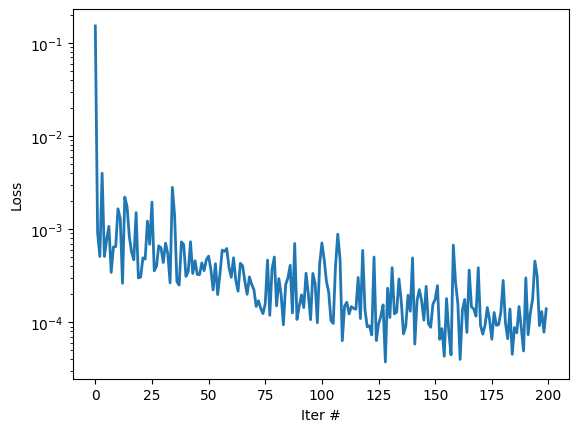

In [ ]:
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
N_dom=10000

xlim=[0,1]
ylim=[0,1]

rng=random.PRNGKey(1235)


domain=random.uniform(rng,minval=xlim[0],maxval=xlim[1],shape=(N_dom,2)) 

In [ ]:
x=domain[:,0:1]
y=domain[:,0:1]

pred=model.predict(opt_params,x,y)

In [ ]:
true_sol=np.sin(math.pi*x)*np.sin(math.pi*y)/2/math.pi**2

In [ ]:
error_norm=np.mean((pred-true_sol)**2)/np.mean(true_sol**2)
print("L2 relative error on test data = ",(error_norm))

L2 relative error on test data =  0.0049647675



## Problem 5 [20 Points]:

Submit a two-page summary of your proposed final project. Make sure you clearly articulate the following:
- An overview of the proposed problem and why it is important.
- What are the challenges to be addressed.
- What is the current state-of-the-art and which are its potential limitations.
- What is the formal mathematical definition of the problem, and what is the technical approach you will employ.
- What is the potential impact upon the successful completion of the project.

Any figures or references should be included within the 2-page limit.



In [ ]:
# please attach a separate PDF document for this question